# Arima Models for California Counties 

In [19]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [15]:
data = pd.read_csv('finalized_county.csv')

In [16]:
california_data = data[data['state'] == 'California']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['county'].unique()

array(['Los Angeles', 'Orange', 'San Diego'], dtype=object)

# Los Angeles

In [10]:
la = california_data[california_data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Los Angeles is non-stationary
print("Stationary or not?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(la.incremental_cases))

# get this value for reversion purposes
print(la.loc[la['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
la['incremental_cases'] = la['incremental_cases'].diff(
).fillna(la['incremental_cases']).astype('int')

# Los Angeles is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(la.incremental_cases))

Stationary or not?: (1.3190762222252403, 0.9967136380720155)
229    823
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-0.934092662079519, 0.7765380334868845)
229   -1293
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-8.591013100393987, 7.286147751265899e-14)


In [11]:
la.shape

(270, 2)

In [12]:
# use 85%-15% for train-test split
train = la.iloc[:230, :]
test = la.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

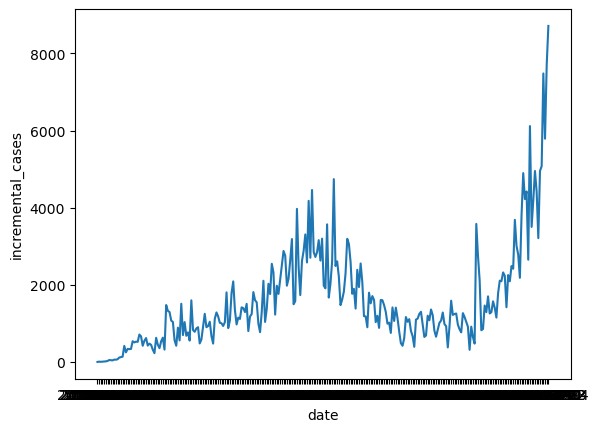

In [13]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Los Angeles'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'train' is your DataFrame with a column named 'incremental_cases'
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

# Seasonal parameters
P_values = [0, 1, 2]  # Seasonal autoregressive order
D_values = [0, 1, 2]  # Seasonal differencing order
Q_values = [0, 1, 2]  # Seasonal moving average order
m_values = [7, 12]    # Seasonal period; adjust based on your data (e.g., 12 for monthly data)

best_score, best_cfg = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                try:
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False).fit(disp=0)
                                    forecast = model.forecast(steps=val_data.shape[0])
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    if mse < best_score:
                                        best_score, best_cfg = mse, ((p, d, q), (P, D, Q, m))
                                except:
                                    continue

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')


Best ARIMA parameters: ((1, 1, 2), (1, 0, 2, 7)) with MSE: 491340.0174897828


In [42]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 1, 2), seasonal_order=(1,0,2,7)).fit()
pred = pd.concat([pd.Series([-1293]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([823]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77075D+00    |proj g|=  1.15765D+00

At iterate    5    f=  7.95663D+00    |proj g|=  6.71510D-02

At iterate   10    f=  7.90168D+00    |proj g|=  8.63345D-03

At iterate   15    f=  7.89812D+00    |proj g|=  1.98768D-03

At iterate   20    f=  7.89781D+00    |proj g|=  1.42531D-03

At iterate   25    f=  7.89657D+00    |proj g|=  1.27659D-02

At iterate   30    f=  7.76015D+00    |proj g|=  3.72961D-02

At iterate   35    f=  7.75776D+00    |proj g|=  5.12959D-03

At iterate   40    f=  7.75693D+00    |proj g|=  8.32680D-04

At iterate   45    f=  7.75573D+00    |proj g|=  4.30389D-02

At iterate   50    f=  7.74608D+00    |proj g|=  1.86307D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<Axes: xlabel='date'>

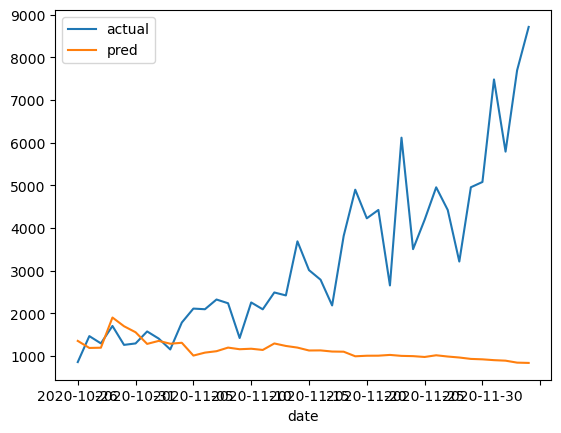

In [43]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 incremental_cases   No. Observations:                  230
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -1781.598
Date:                           Fri, 23 Feb 2024   AIC                           3577.196
Time:                                   22:30:59   BIC                           3601.233
Sample:                                        0   HQIC                          3586.893
                                           - 230                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3742      0.052     -7.198      0.000      -0.476      -0.272
ma.L1         -1.9998      0.054    -36.817      0.000      -2.106      -1.893
ma.L2          0.9998      0.055     18.290      0.000       0.893       1.107
ar.S.L7       -0.5728      0.355     -1.615      0.106      -1.268       0.122
ma.S.L7        0.8189      0.385      2.128      0.033       0.065       1.573
ma.S.L14       0.0460      0.150      0.308      0.758      -0.247       0.339
sigma2      3.148e+05   3.46e-07    9.1e+11      0.000    3.15e+05    3.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):               370.62
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               3.43   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.73e+28. Standard errors may be unstable.
"""

### Best Model:

Best SARIMA parameters: (1, 1, 2)x(1, 0, 2, 7) with MSE: 491340.01748978
r^2 = -1.4084564890201

# Orange

In [81]:
orange = california_data[california_data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
orange['incremental_cases'] = orange['incremental_cases'].astype('int')
orange['date'] = pd.to_datetime(orange['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Orange is non-stationary
print("Stationary or not?:", stationary_test(orange.incremental_cases))

# get this value for reversion purposes
print(orange.loc[orange['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
orange['incremental_cases'] = orange['incremental_cases'].diff(
).fillna(orange['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(orange.incremental_cases))

Stationary or not?: (-0.1897980045327783, 0.9397267929055788)
499    247
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-10.476734705085976, 1.243438566263163e-18)


In [82]:
orange.shape

(270, 2)

In [83]:
# use 85%-15% for train-test split
train = orange.iloc[:230, :]
test = orange.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

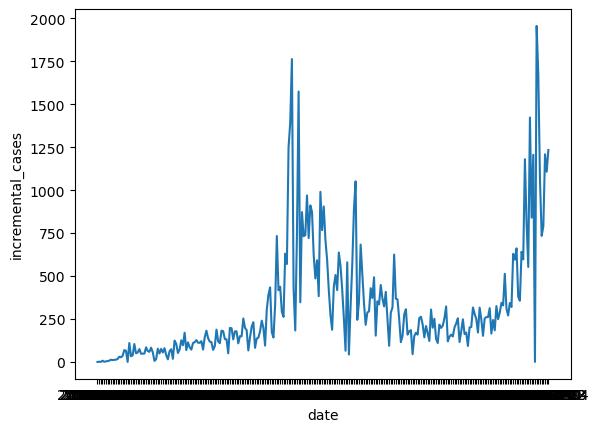

In [84]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Orange'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [54]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'train' is your DataFrame with a column named 'incremental_cases'
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

# Seasonal parameters
P_values = [0, 1, 2]  # Seasonal autoregressive order
D_values = [0, 1, 2]  # Seasonal differencing order
Q_values = [0, 1, 2]  # Seasonal moving average order
m_values = [7, 12]    # Seasonal period; adjust based on your data (e.g., 12 for monthly data)

best_score, best_cfg = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                try:
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False).fit(disp=0)
                                    forecast = model.forecast(steps=val_data.shape[0])
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    if mse < best_score:
                                        best_score, best_cfg = mse, ((p, d, q), (P, D, Q, m))
                                except:
                                    continue

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: ((2, 0, 2), (0, 1, 2, 7)) with MSE: 8898.252671457201


In [89]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(2, 0, 2), seasonal_order=(0,1,2,7)).fit()
pred = pd.concat([pd.Series([247]), model.forecast(steps=40)]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76819D+00    |proj g|=  4.15668D-01

At iterate    5    f=  6.57001D+00    |proj g|=  1.58327D-02

At iterate   10    f=  6.56475D+00    |proj g|=  5.42555D-03

At iterate   15    f=  6.56117D+00    |proj g|=  2.61822D-02

At iterate   20    f=  6.55536D+00    |proj g|=  2.04158D-03

At iterate   25    f=  6.53905D+00    |proj g|=  2.11537D-02

At iterate   30    f=  6.45299D+00    |proj g|=  3.43060D-02

At iterate   35    f=  6.44897D+00    |proj g|=  9.77493D-03

At iterate   40    f=  6.44423D+00    |proj g|=  6.62471D-03

At iterate   45    f=  6.44068D+00    |proj g|=  2.42908D-03

At iterate   50    f=  6.43313D+00    |proj g|=  4.76770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<Axes: xlabel='date'>

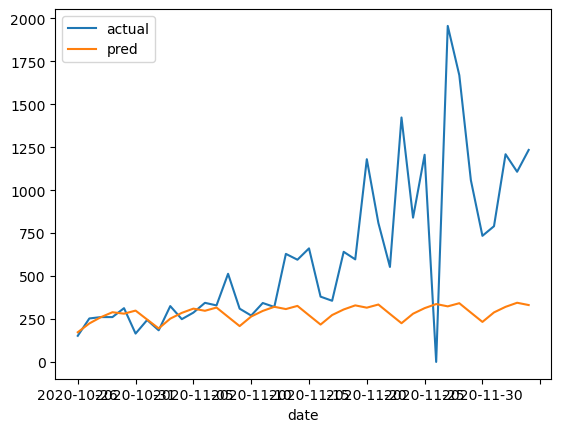

In [90]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [91]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 incremental_cases   No. Observations:                  230
Model:             SARIMAX(2, 0, 2)x(0, 1, 2, 7)   Log Likelihood               -1479.619
Date:                           Sat, 24 Feb 2024   AIC                           2973.238
Time:                                   12:40:38   BIC                           2997.088
Sample:                                        0   HQIC                          2982.866
                                           - 230                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1529      0.082     14.123      0.000       0.993       1.313
ar.L2         -0.2774      0.043     -6.481      0.000      -0.361      -0.194
ma.L1         -1.7400      0.080    -21.700      0.000      -1.897      -1.583
ma.L2          0.7939      0.064     12.472      0.000       0.669       0.919
ma.S.L7       -1.0255      0.056    -18.438      0.000      -1.135      -0.917
ma.S.L14       0.0261      0.049      0.530      0.596      -0.070       0.122
sigma2      2.697e+04    2.1e-06   1.29e+10      0.000     2.7e+04     2.7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               656.24
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               8.17   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.18e+25. Standard errors may be unstable.
"""

# San Diego

In [92]:
sandiego = california_data[california_data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
sandiego['incremental_cases'] = sandiego['incremental_cases'].astype('int')
sandiego['date'] = pd.to_datetime(sandiego['date'], format="%Y-%m-%d")

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Los Angeles is non-stationary
print("Stationary or not?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# first-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# Los Angeles is still non-stationary after first-level differencing
print("Stationary after first level diff?:", stationary_test(sandiego.incremental_cases))

# get this value for reversion purposes
print(sandiego.loc[sandiego['date'] == '2020-10-25', 'incremental_cases'])

# second-level differencing
sandiego['incremental_cases'] = sandiego['incremental_cases'].diff(
).fillna(sandiego['incremental_cases']).astype('int')

# Los Angeles is stationary after second-level differencing
print("Stationary after second level diff?:", stationary_test(sandiego.incremental_cases))

Stationary or not?: (0.6357611259888307, 0.9884647007943559)
769    269
Name: incremental_cases, dtype: int64
Stationary after first level diff?: (-1.5064452750852018, 0.5303205781258837)
769   -117
Name: incremental_cases, dtype: int64
Stationary after second level diff?: (-7.545305190841254, 3.2955778088676166e-11)


In [93]:
sandiego.shape

(270, 2)

In [94]:
# use 85%-15% for train-test split
train = sandiego.iloc[:230, :]
test = sandiego.iloc[230:, :]

<Axes: xlabel='date', ylabel='incremental_cases'>

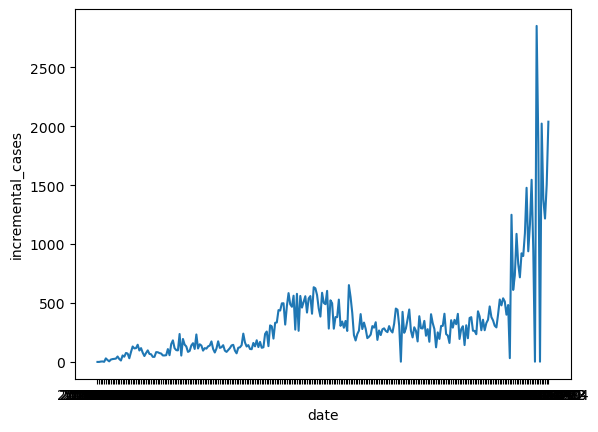

In [95]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'San Diego'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [70]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'train' is your DataFrame with a column named 'incremental_cases'
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

# Non-seasonal ARIMA parameters
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

# Seasonal parameters
P_values = [0, 1, 2]  # Seasonal autoregressive order
D_values = [0, 1, 2]  # Seasonal differencing order
Q_values = [0, 1, 2]  # Seasonal moving average order
m_values = [7, 12]    # Seasonal period; adjust based on your data (e.g., 12 for monthly data)

best_score, best_cfg = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                try:
                                    model = SARIMAX(train_data.incremental_cases,
                                                    order=(p, d, q),
                                                    seasonal_order=(P, D, Q, m),
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False).fit(disp=0)
                                    forecast = model.forecast(steps=val_data.shape[0])
                                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                                    if mse < best_score:
                                        best_score, best_cfg = mse, ((p, d, q), (P, D, Q, m))
                                except:
                                    continue

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: ((1, 1, 1), (1, 0, 2, 7)) with MSE: 11802.57017781215


In [96]:
model = sm.tsa.statespace.SARIMAX(train.incremental_cases, order=(1, 1, 1), seasonal_order=(1,0,2,7)).fit()
pred = pd.concat([pd.Series([269]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([-117]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
print("R-squared", r2) 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33493D+00    |proj g|=  2.11177D-01

At iterate    5    f=  6.28073D+00    |proj g|=  5.38585D-03

At iterate   10    f=  6.27186D+00    |proj g|=  1.55503D-02


 This problem is unconstrained.



At iterate   15    f=  6.26904D+00    |proj g|=  2.78126D-03

At iterate   20    f=  6.24770D+00    |proj g|=  2.78013D-02
  ys=-2.175E-03  -gs= 2.143E-03 BFGS update SKIPPED

At iterate   25    f=  6.23955D+00    |proj g|=  1.48445D-02

At iterate   30    f=  6.23122D+00    |proj g|=  1.88327D-04

At iterate   35    f=  6.23122D+00    |proj g|=  1.36034D-04

At iterate   40    f=  6.23118D+00    |proj g|=  4.40944D-04

At iterate   45    f=  6.23116D+00    |proj g|=  3.03494D-04

At iterate   50    f=  6.23116D+00    |proj g|=  9.24621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     1

<Axes: xlabel='date'>

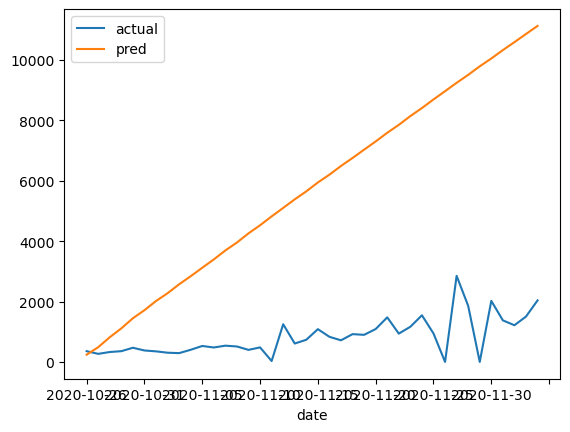

In [97]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

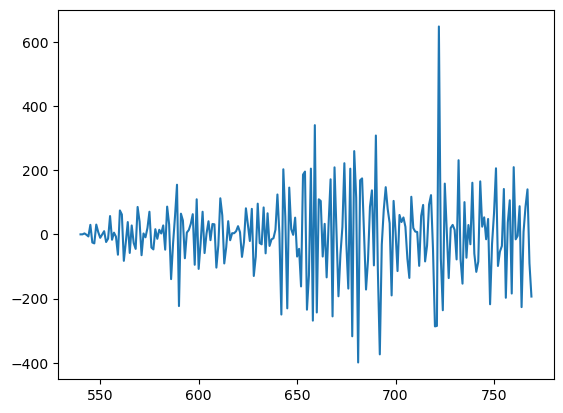

In [98]:
plt.plot(model.resid)

In [80]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                      incremental_cases   No. Observations:                  230
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -1433.166
Date:                                Sat, 24 Feb 2024   AIC                           2878.333
Time:                                        00:46:53   BIC                           2898.935
Sample:                                             0   HQIC                          2886.644
                                                - 230                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7239      0.036    -20.371      0.000      -0.794      -0.654
ma.L1         -0.9998      4.447     -0.225      0.822      -9.715       7.715
ar.S.L7       -0.8409      0.128     -6.546      0.000      -1.093      -0.589
ma.S.L7        1.1470      8.076      0.142      0.887     -14.681      16.975
ma.S.L14       0.1474      1.230      0.120      0.905      -2.264       2.559
sigma2      1.488e+04   1.29e+05      0.116      0.908   -2.37e+05    2.67e+05
===================================================================================
Ljung-Box (L1) (Q):                  24.12   Jarque-Bera (JB):               112.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.68   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""